In [22]:
import torch

In [1]:
import os

In [2]:
os.chdir('/content/drive/MyDrive/Text Classification')

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import pandas as pd
df=pd.read_csv('IMDB Dataset.csv')

In [5]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)

# Data analysis

In [6]:
from collections import Counter
import re

In [7]:
import numpy as np

In [8]:
import nltk

In [9]:
from nltk.corpus import stopwords 

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
stop_words = set(stopwords.words('english'))

In [12]:
def preprocess_sen(s):

  # Remove all non-word characters (everything except numbers and letters)
  s = re.sub(r"[^\w\s]", '', s)
  # Replace all runs of whitespaces with no space
  s = re.sub(r"\s+"," ", s)
  # replace digits with no space
  s = re.sub(r"\d", '', s)

  return s


In [15]:
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []
    
    for sen in x_train:
      sen=sen.lower()
      sen=preprocess_sen(sen)
      
      for word in sen.split():
        if word not in stop_words:
          word_list.append(word)

    word_freq=Counter(word_list)
    imp_words = sorted(word_freq,key=word_freq.get,reverse=True)[:3000]
    
    onehot_dict = {w:i+1 for i,w in enumerate(imp_words)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
      sent=sent.lower()
      sent=preprocess_sen(sent)
      final_list_train.append([onehot_dict[word] for word in sent.split() 
                                     if word in onehot_dict.keys()])
    for sent in x_val:
      sent=sent.lower()
      sent=preprocess_sen(sent)
      final_list_test.append([onehot_dict[word] for word in sent.split() if word in onehot_dict.keys()])
  
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [16]:
X_train,y_train,X_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [17]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 3000


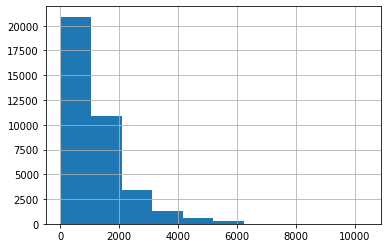

count    37500.000000
mean      1307.100160
std        978.422371
min         32.000000
25%        699.000000
50%        970.000000
75%       1591.000000
max      10363.000000
dtype: float64

In [18]:
import matplotlib.pyplot as plt
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [19]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [20]:
X_train_pad = padding_(X_train,1000)
X_test_pad = padding_(X_test,1000)

In [23]:
from torch.utils.data import TensorDataset, DataLoader
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [24]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 1000])
Sample input: 
 tensor([[   0,    0,    0,  ...,    3, 1940,  687],
        [   0,    0,    0,  ...,    2,   70, 1300],
        [   0,    0,    0,  ...,   87,  973,    3],
        ...,
        [   0,    0,    0,  ...,   43,   57,    2],
        [   0,    0,    0,  ...,  371,   16,  566],
        [   0,    0,    0,  ...,  259, 1188,  354]])
Sample input: 
 tensor([0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0])


# Model

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

              

In [26]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [27]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)


SentimentRNN(
  (embedding): Embedding(3001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [28]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [31]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.2947704809308052 val_loss : 0.2959631260037422
train_accuracy : 87.58666666666667 val_accuracy : 87.58399999999999
Validation loss decreased (inf --> 0.295963).  Saving model ...
Epoch 2
train_loss : 0.25420869003733 val_loss : 0.29820521467924116
train_accuracy : 89.656 val_accuracy : 87.67200000000001
Epoch 3
train_loss : 0.21790188250442347 val_loss : 0.3201303503662348
train_accuracy : 91.30933333333333 val_accuracy : 87.536
Epoch 4
train_loss : 0.17319306964427233 val_loss : 0.31275515326857567
train_accuracy : 93.304 val_accuracy : 87.78399999999999
Epoch 5
train_loss : 0.11554183307910959 val_loss : 0.3835387982279062
train_accuracy : 95.78933333333333 val_accuracy : 87.264


In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()